# Analyze the variation of the Grimsvötn

In [1]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy
import math
import datetime
import time
import obspy
from obspy.signal import PPSD

In [2]:
def RMS_smoothing(rL, time,nbrpt = None) :
    rL = np.array(rL)
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[],[]] #0 is rms
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            rms = np.sqrt(np.sum(rL[i:i+nbrpt]**2)/nbrpt)
            mode = scipy.stats.mode(rL[i:i+nbrpt],keepdims=True)[0][0]
            hist, bin_edges = np.histogram(rL[i:i+nbrpt], density=True)
            mode_np = hist.max()
            output[0].append(rms)
            output[1].append(mode)
            output[2].append(mode_np)
            output[3].append(time[i])
    return np.array(output)

In [3]:
"""
Fonction qui fait la mediane sur une succession de points
output[0] = median
output[1] = std
output[2] = time
"""
def medGPS_linear(rL, time,nbrpt = None) :
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[]] #0 is median
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            output[0].append(np.median(rL[i:i+nbrpt]))
            output[1].append(np.std(rL[i:i+nbrpt]))
            output[2].append(time[i])
    return np.array(output)

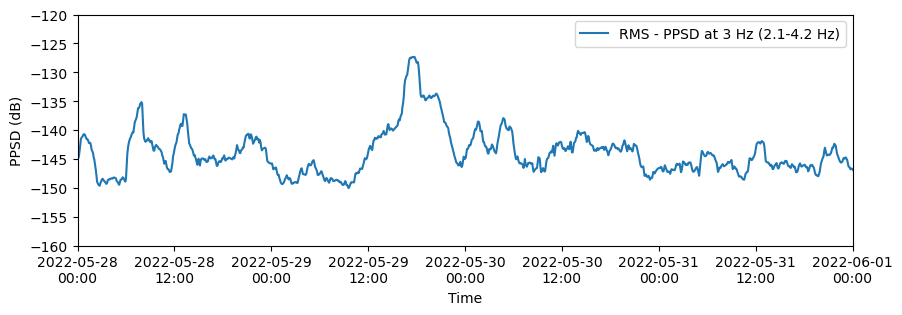

In [4]:
Snpz = '20742'
stt = '4530%s_ppsdZ.npz'%Snpz
ppsd = PPSD.load_npz('./ppsd/nodes_vatna/%s'%stt)
#ppsd.plot_temporal([1/15,1/3])

Pwater =ppsd.extract_psd_values(1/3)[0]
Psed = ppsd.extract_psd_values(1/15)[0]
T = ppsd.times_processed

sPwater = RMS_smoothing(Pwater, T,nbrpt=24)
sPsed = RMS_smoothing(Psed, T,nbrpt=24)
medPwater = medGPS_linear(Pwater, T, nbrpt=8)

fig, ax = plt.subplots(figsize = (10,3))

ax.plot(sPwater[3].astype('datetime64[s]'),-sPwater[0],label='RMS - PPSD at 3 Hz (2.1-4.2 Hz)')
ax.set_ylabel('PPSD (dB)')
ax.set_xlabel('Time')
ax.set_ylim(-160,-120)
ax.set_xlim(sPwater[3][0],np.datetime64('2022-06-01'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
ax.legend()


Text(0, 0.5, 'Broadband seismometer HHZ\nDisplacement (m)')

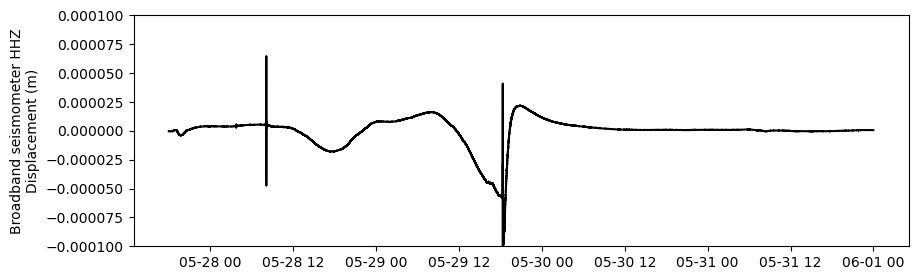

In [5]:
traceZ = obspy.read("./Grims_Varia/DISP-Corrected-HHZ_centaur-6_27052022to31052022.mseed")

dt = np.arange(0,traceZ[0].stats.npts) #make array which its length = trace length
dt = dt*traceZ[0].stats.delta #array of dt from starttime
trtime = dt.astype('timedelta64[s]') + np.datetime64(traceZ[0].stats.starttime)

fig, ax1 = plt.subplots(figsize=(10,3))
#t.plot()
ax1.plot(trtime,traceZ[0],c='k')
ax1.set_ylim(-.0001,.0001)
ax1.set_ylabel('Broadband seismometer HHZ\nDisplacement (m)')

Text(0, 0.5, 'Broadband seismometer HHZ\nDisplacement (m)')

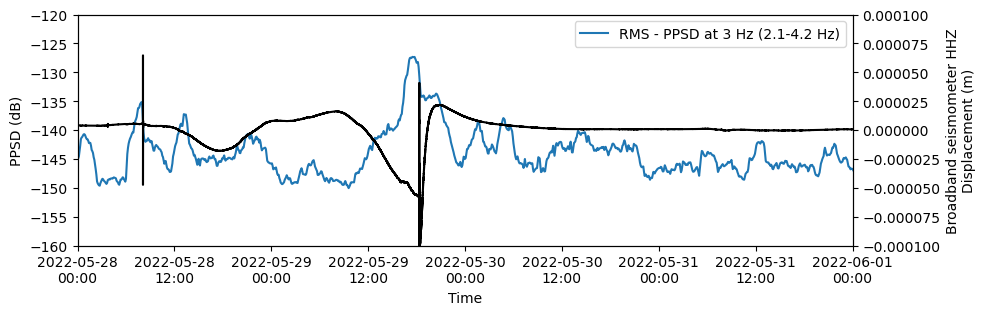

In [14]:
fig, ax = plt.subplots(figsize = (10,3), sharex=True)

ax.plot(sPwater[3].astype('datetime64[s]'),-sPwater[0],label='RMS - PPSD at 3 Hz (2.1-4.2 Hz)')
ax.set_ylabel('PPSD (dB)')
ax.set_ylim(-160,-120)
ax.set_xlim(sPwater[3][0],np.datetime64('2022-06-01'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
ax.legend()

axb = ax.twinx()
axb.plot(trtime,traceZ[0],c='k', label='GT.RNTR6.HHZ')
axb.set_ylim(-.0001,.0001)
axb.set_ylabel('Broadband seismometer HHZ\nDisplacement (m)')

In [6]:
sF0 = []
stHV = []
for s in ['453020742','453020762','453020780'] :
    root = './res_continuous_HVSR/%s/' %s
    files = os.listdir(root)
    F0 = []
    tHV = []
    for i, file, in enumerate(files) :
        if file[0:4] == 'mean' :
            break
        rfile = pd.read_csv(root+file)
        argmaxAMP = np.argmax(rfile.AMP)
        f0 = rfile.FREQ[argmaxAMP]
        tHV.append(np.datetime64(rfile.starttime[0])+30*60)
        F0.append(f0)
    sF0.append(F0)
    stHV.append(tHV)


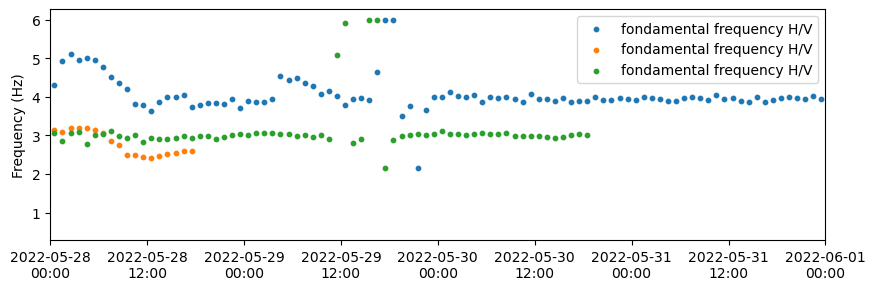

In [7]:
fig, ax = plt.subplots(figsize = (10,3))
for i, Frq, in enumerate(sF0) :
    meanFrq = np.mean(Frq)
    ax.scatter(stHV[i],Frq,label='Fundamental frequency H/V', s=10)
ax.set_ylabel('Frequency (Hz)')

ax.set_xlim(sPwater[3][0],np.datetime64('2022-06-01'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
ax.legend()

Text(0, 0.5, 'Broadband seismometer HHZ\nDisplacement (m)')

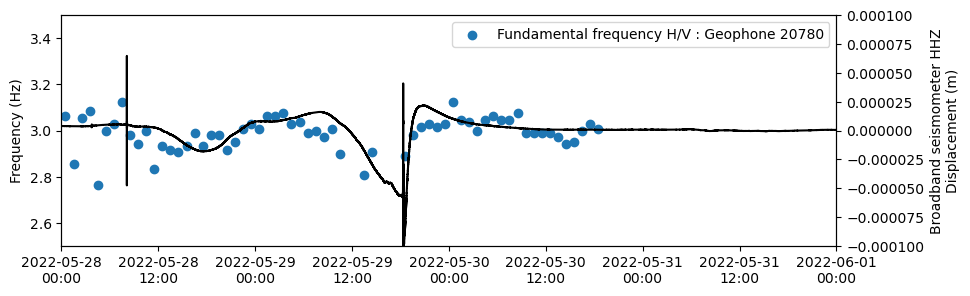

In [12]:
fig, ax = plt.subplots(figsize = (10,3), sharex=True)

ax.scatter(stHV[2],sF0[2],label='Fundamental frequency H/V : Geophone 20780')
ax.set_ylabel('Frequency (Hz)')
ax.set_ylim(2.5,3.5)
ax.set_xlim(sPwater[3][0],np.datetime64('2022-06-01'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
ax.legend()

axb = ax.twinx()
axb.plot(trtime,traceZ[0],c='k', label='GT.RNTR6.HHZ')
axb.set_ylim(-.0001,.0001)
axb.set_ylabel('Broadband seismometer HHZ\nDisplacement (m)')